In [39]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
# 
_set_env("ANTHROPIC_API_KEY")
_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "patient-ai-chat"

In [11]:
prompt_text = '''You are a helpful AI medical assistant specialized in making medical insights. You also take 
account patient name, date of birth, medical conditions and medications that are taken by a patient. You will build 
your responses based on these information and other provided medical knowledge. Now use your medical expertise to 
provide a comprehensive medical insight for the texts below:'''

In [44]:
from langchain_anthropic import ChatAnthropic
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import START, StateGraph, MessagesState, END
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.graphs import Neo4jGraph
from langchain_community.chains.graph_qa.prompts import CYPHER_GENERATION_PROMPT
from langchain.chains import GraphCypherQAChain  
from langchain_community.graphs import Neo4jGraph  
from langchain_core.documents import Document  
from langchain_experimental.graph_transformers import LLMGraphTransformer

model= ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0)

I0000 00:00:1727818089.132627 14395629 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1727818090.174539 14395629 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


In [45]:
from typing import List

class State(MessagesState):
    name: str
    medications: List[str]
    medical_conditions: List[str]

In [46]:
def fetch_user_info(state: State):
    return {"name": "", "medications": ["a", "b"], "medical_conditions": ["c"]}

# def assistant(state: State):
#     # Prompt message
#     sys_msg = SystemMessage(content=prompt_text)
#     return {"messages": [model.invoke([sys_msg] + state["messages"])]}

def query_knowledge_graph(state: State):
    graph = Neo4jGraph()
    chain = GraphCypherQAChain.from_llm(graph=graph, llm=model, verbose=True, validate_cypher=True, allow_dangerous_requests = True, top_k = 5, cypher_prompt=CYPHER_GENERATION_PROMPT )  
    response = chain.invoke({"query": messages})  
    return response

In [47]:
def build_graph() -> StateGraph:
    builder = StateGraph(State)
    builder.add_node("fetch_user_info", fetch_user_info)
    builder.add_node("query_knowledge_graph", query_knowledge_graph)
    
    builder.add_edge(START, "fetch_user_info")
    builder.add_edge( "fetch_user_info", "query_knowledge_graph")
    builder.add_edge("query_knowledge_graph", END)
    
    return builder



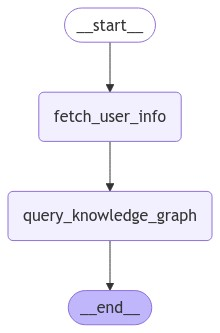

In [48]:
from IPython.display import Image, display

memory = MemorySaver()
graph = build_graph().compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [49]:
from pprint import pprint

messages = [HumanMessage(content="My name is Sajed")]
config = {"configurable": {"thread_id": "5"}}
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()
    
pprint(messages)

ValueError: Did not find url, please add an environment variable `NEO4J_URI` which contains it, or pass `url` as a named parameter.

In [63]:
messages = [HumanMessage(content="What is my name? and I have fever now")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()
    
pprint(messages)

================================ Human Message =================================

My name is Sajed
================================== Ai Message ==================================

It's nice to meet you Sajed. As an AI medical assistant, I'm happy to chat with you about health-related topics. How can I assist you today? Please let me know if you have any questions about your health, medication, lifestyle, or if you need help with any medical requests like appointment scheduling or medication changes. I'm here to help in whatever way I can.
================================ Human Message =================================

My name is Sajed
================================== Ai Message ==================================

Okay, got it. I understand your name is Sajed. As an AI medical assistant, I'm happy to chat with you about any health-related topics you'd like to discuss. Please feel free to ask me questions about your health, medication, lifestyle, or if you need assistance with things

In [ ]:
graph.get_state(config).values.get("summary","")

In [ ]:
messages = [HumanMessage(content="What is my name?")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

In [ ]:
graph.get_state(config).values.get("summary","")

In [ ]:
messages = [HumanMessage(content="I have an appointmnet on October 9. I want to reschedule it to November 5th.")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

In [ ]:
graph.get_state(thread).values.get("summary","")